In [1]:
import qdmpy
import qdmpy.pl
import qdmpy.plot
import qdmpy.field
import qdmpy.source

import matplotlib
import numpy as np

In [2]:
# '%matplotlib widget' allows interactive plots in jupyterlab
# use ''%matplotlib inline' to allow export to pdf
# %matplotlib widget

### Load raw data

In [3]:
options_dict = {
    "base_dir": "/home/samsc/ResearchData/test_images/global_pl_test/",
    "filepath": "ODMR - Pulsed_128",
    "custom_output_dir_suffix": "_{ROI}_bin_{total_bin}",
    
    "additional_bins": 4,
    
    "exp_reference_type": "field",
    "plot_bnv_flip_with_bias_mag": False,
    
    "system_name": "Cryo_Widefield",

    "ROI": "Rectangle", 
#     "ROI_start": [250, 250],
#     "ROI_end": [400,450],
    "ROI_start": [125, 125],
    "ROI_end": [200,225],
    
    "fit_backend": "scipyfit",
    "fit_backend_comparison": ["scipyfit"],
    "fit_pixels": True, 
    "force_fit": False, 

    "use_ROI_avg_fit_res_for_all_pixels": True,    
    "scipyfit_sub_threads": 2, 

    "fit_functions":  {"linear": 1, "lorentzian": 2},

    "pos_guess": [2730, 3020],
    "pos_range": 25,

    "amp_guess": -0.015,
    "amp_bounds": [-0.300, -0.00003],
    
    "fwhm_bounds": [0, 100],
    
    "save_fig_type": "pdf",
    
    "freqs_to_use": [1, 0, 0, 0, 0, 0, 0, 1],
    "diamond_ori": "<100>_<100>", # HPHT
    
    "auto_read_bias": True,
    
    "colormap_range_dicts": {
        "bnv_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "bfield_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "magnetization_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "residual_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "sigma_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "param_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "dshift_images": {
            "type": "percentile",
            "values": [2, 98]
        },
    }
}

In [4]:
options, ref_options = qdmpy.initialize(
    options_dict=options_dict,
    ref_options_dir=None,
    set_mpl_rcparams=True
)

/home/samsc/.local/lib/python3.8/site-packages/qdmpy/interface.py:525: UserWarning: Option fit_pixels was not recognised by the Cryo Widefield system.
  warnings.warn(f"Option {key} was not recognised by the {system.name} system.")
/home/samsc/.local/lib/python3.8/site-packages/qdmpy/interface.py:226: UserWarning: Continuing without reference. (No reference chosen or exp_referece_type was 'None')
  warnings.warn(


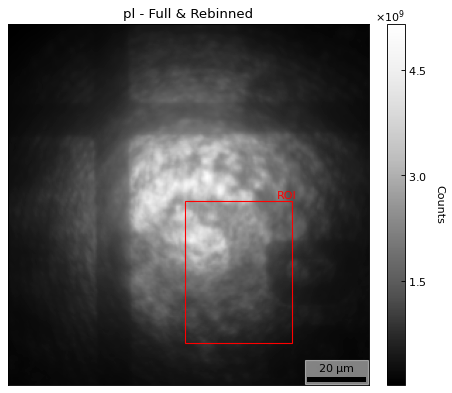

In [5]:
image, prelim_sweep_list = qdmpy.pl.load_image_and_sweep(options)
PL_image, PL_image_ROI, sig, ref, full_sig_norm, single_pixel_pl, sweep_list, ROI = qdmpy.pl.reshape_dataset(
        options, image, prelim_sweep_list
    )

ROI_PL_fig = qdmpy.plot.roi_pl_image(options, PL_image)
qdmpy.pl.save_pl_data(options, PL_image, PL_image_ROI)

/home/samsc/.local/lib/python3.8/site-packages/qdmpy/pl/scipyfit.py:35: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # auto detects jupyter


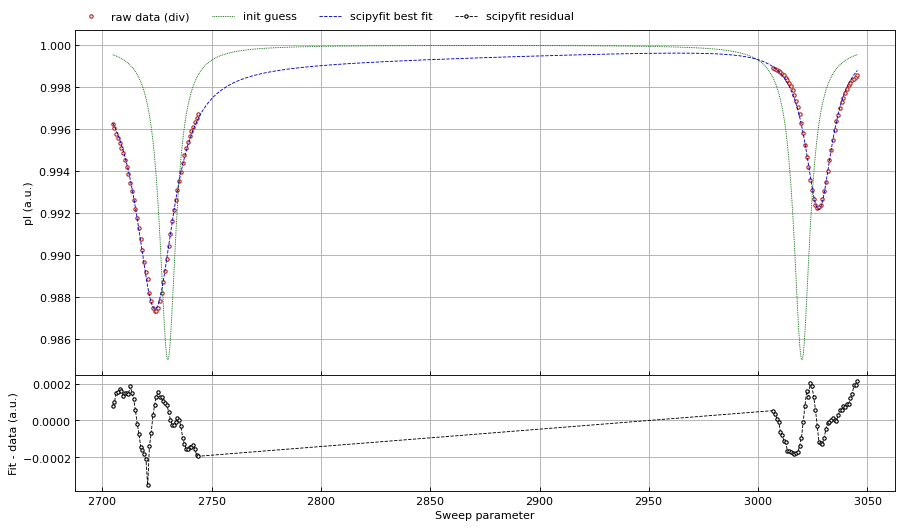

In [6]:
fit_model = qdmpy.pl.define_fit_model(options)
backend_ROI_results_lst = qdmpy.pl.fit_roi_avg_pl(options, full_sig_norm, sweep_list, fit_model)
ROI_fit_fig = qdmpy.plot.roi_avg_fits(options, backend_ROI_results_lst)
wanted_roi_result = next(
    filter(
        lambda result: result.fit_backend == options["fit_backend"], backend_ROI_results_lst
    )
) # ROI fit result for chosen fit backend

In [7]:
# # test subtraction
# full_sig_norm.shape
# a = np.linspace(1, 99, 99)
# x = full_sig_norm - a[:, None, None]
# x.shape

In [8]:
fwhms = []
g_vec = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for g in g_vec:
    # subtract g * roi_fit from every pixel in sig_norm.
    roi_fit_vec = wanted_roi_result.fit_model(wanted_roi_result.best_params, wanted_roi_result.sweep_list)
    
    sig_norm = full_sig_norm - roi_fit_vec[:, None, None]
    pixel_fit_params, sigmas = qdmpy.pl.get_pl_fit_result(options, sig_norm, sweep_list, fit_model, wanted_roi_result)
    fwhms.append([pixel_fit_params["fwhm_0"], pixel_fit_params["fwhm_1"]])

  0%|          | 0/7676 [00:00<?, ? PX/s]

  0%|          | 0/7676 [00:00<?, ? PX/s]

  0%|          | 0/7676 [00:00<?, ? PX/s]

  0%|          | 0/7676 [00:00<?, ? PX/s]

  0%|          | 0/7676 [00:00<?, ? PX/s]

  0%|          | 0/7676 [00:00<?, ? PX/s]

  0%|          | 0/7676 [00:00<?, ? PX/s]

  0%|          | 0/7676 [00:00<?, ? PX/s]

  0%|          | 0/7676 [00:00<?, ? PX/s]

In [13]:
root_path = r"/home/samsc/ResearchData/test_images/global_pl_test/"
for i, (zero, one) in enumerate(fwhms):
    np.savetxt(root_path + f"{i}_0.txt", zero)
    np.savetxt(root_path + f"{i}_1.txt", one)

### Plot (fit) parameters

In [9]:
# qdmpy.pl.save_pl_fit_results(options, pixel_fit_params)
# qdmpy.pl.save_pl_fit_sigmas(options, sigmas)
# c_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "c")
# m_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "m")
# pos_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "pos")
# amp_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "amp")
# fwhm_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "fwhm")
# residual_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "residual")
# pos_sigma_plot = qdmpy.plot.pl_param_images(options, fit_model, sigmas, "pos", errorplot=True)

### Field retrieval

In [10]:
# field_res = qdmpy.field.odmr_field_retrieval(options, pixel_fit_params, ref_fit_params)
# (sig_bnvs, ref_bnvs, bnvs), (sig_dshifts, ref_dshifts), (sig_params, ref_params, field_params), (sig_field_sigmas, ref_field_sigmas, field_sigmas) = field_res
# qdmpy.field.save_field_calcs(options, *field_res)
# bnv_sig_plot = qdmpy.plot.bnvs_and_dshifts(options, "sig", sig_bnvs, sig_dshifts)
# bnv_ref_plot = qdmpy.plot.bnvs_and_dshifts(options, "ref", ref_bnvs, ref_dshifts)
# bnvs_plot = qdmpy.plot.bnvs_and_dshifts(options, "sig_sub_ref", bnvs, [])
# bfield_sig_plot = qdmpy.plot.bfield(options, "sig", sig_params)
# bfield_ref_plot = qdmpy.plot.bfield(options, "ref", ref_params)
# bfield_plot = qdmpy.plot.bfield(options, "sig_sub_ref", field_params)
# bfield_bground_plot = qdmpy.plot.bfield(options, "bground", field_params)
# D_sig_plot = qdmpy.plot.dshift_fit(options, "sig", sig_params)
# D_ref_plot = qdmpy.plot.dshift_fit(options, "ref", ref_params)
# bconsist_plot = qdmpy.plot.bfield_consistency(options, "sig_sub_ref", field_params)
# source_params = qdmpy.source.odmr_source_retrieval(options, bnvs, field_params)
# qdmpy.source.save_source_params(options, source_params)
# mag_plot = qdmpy.plot.magnetization(options, source_params, plot_bgrounds=True)
# qdmpy.field.add_bfield_proj_bias(options, field_params)
# btp_plot = qdmpy.plot.bfield_theta_phi(options, "sig_sub_ref", field_params)

### Save and (optionally) view options dict

In [11]:
qdmpy.save_options(options)
# import qdmpy.shared.json2dict; print(qdmpy.shared.json2dict.dict_to_json_str(options))

## 